# Goal

This notebook imports the pyPI code and sample data, computes the PI module (pi.py) output, and then performs seasonal analyses on PI data. The sample data are MERRA2 monthly averages from 2004. The goal of this notebook is to demonstrate a few analyses that can be performed with PI calculations. See Gilford et al. ([2017](https://journals.ametsoc.org/doi/full/10.1175/JCLI-D-16-0827.1); [2019](https://journals.ametsoc.org/doi/10.1175/MWR-D-19-0021.1)) for more examples that were performed with the BE02 MATLAB algorithm.

In [95]:
import sys
sys.path.append(sys.path[0]+'/..')
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import time
# load PI calculation module
from tcpyPI import pi
# imports utility functions
from tcpyPI.utilities import *

In [96]:
# change default figure font settings
font = {'family' : 'sans-serif',
        'weight' : 1,
        'size'   : 16}

matplotlib.rc('font', **font)
monlabels=['J','F','M','A','M','J','J','A','S','O','N','D']

# Load Data

In [97]:
# data location
data_loc='../data/sample_data.nc'
data_loc="/Users/ncolombi/Desktop/ensemble_members/combined_variables_tcpi/variables_PI_all.nc"
# load netcdf file
ds_all = xr.open_dataset(data_loc)

# define the CKCD ratio
CKCD=0.9

In [121]:
ds = ds_all.isel(scenario=0).mean(dim="ENS")
ds

<xarray.Dataset> Size: 22MB
Dimensions:   (lon: 144, lat: 90, p: 17, month: 12)
Coordinates:
  * lon       (lon) float64 1kB -178.8 -176.2 -173.8 ... 173.8 176.2 178.8
  * lat       (lat) float64 720B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * p         (p) float32 68B 1e+03 925.0 850.0 700.0 ... 50.0 30.0 20.0 10.0
  * month     (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
    st_ocean  float64 8B 5.0
Data variables:
    q         (month, p, lat, lon) float32 11MB nan nan ... 0.002742 0.002742
    t         (month, p, lat, lon) float32 11MB nan nan nan ... -79.83 -79.83
    msl       (month, lat, lon) float32 622kB 1.002e+03 1.002e+03 ... 1.016e+03
    sst       (month, lat, lon) float32 622kB nan nan nan ... -1.692 -1.691

# Calculate PI and Variables

PI is given by the Bister and Emanuel (2002) algorithm (see pi.py):

In [99]:
# create a function to calculate PI over the sample dataset using xarray
def run_sample_dataset(ds, dim='p'):
    
    # calculate PI over the whole data set using the xarray universal function
    result = xr.apply_ufunc(
        pi,
        ds['sst'], ds['msl'], ds['p'], ds['t'], ds['q'],
        kwargs=dict(CKCD=CKCD, ascent_flag=0, diss_flag=1, ptop=50, miss_handle=1),
        input_core_dims=[
            [], [], ['p', ], ['p', ], ['p', ],
        ],
        output_core_dims=[
            [], [], [], [], []
        ],
        vectorize=True
    )

    vmax, pmin, ifl, t0, otl = result
    
    out_ds=xr.Dataset({
        'vmax': vmax, 
        'pmin': pmin,
        'ifl': ifl,
        't0': t0,
        'otl': otl
    })
    
    # add names and units
    out_ds.vmax.attrs['standard_name'],out_ds.vmax.attrs['units']='Maximum Potential Intensity','m/s'
    out_ds.pmin.attrs['standard_name'],out_ds.pmin.attrs['units']='Minimum Central Pressure','hPa'
    out_ds.ifl.attrs['standard_name']='pyPI Flag'
    out_ds.t0.attrs['standard_name'],out_ds.t0.attrs['units']='Outflow Temperature','K'
    out_ds.otl.attrs['standard_name'],out_ds.otl.attrs['units']='Outflow Temperature Level','hPa'

    # return the output as an xarray data structure
    return out_ds

In [100]:
# calculate PI over the sample data
pi_ds=run_sample_dataset(ds)

## Main development regions (MDRs)

For these analyses, define the TC main development regions following Gilford et al. (2017), centered on these values:

<img src="../figures/mdrs.png" alt="Drawing" style="width: 400px;"/>

In [101]:
# find grid spacing and set bounds from central points according with it
xl=np.abs(ds.lon[1]-ds.lon[0])/2
yl=np.abs(ds.lat[1]-ds.lat[0])/2
# create the basins and store in a dictionary:
na=xr.Dataset({
        'color': 'red', 
        'bounds': xr.DataArray(np.asarray([8.75-yl, 31.25+yl, convert_lon_to180(266.25-xl), convert_lon_to180(308.75+xl)]).reshape(2,2), coords=[[0,1], [0,1]], dims=['lat_range', 'lon_range']),
        'name': 'North Atlantic',
        'shortname': 'NA',
    })
enp=xr.Dataset({
        'color': 'darkgreen', 
        'bounds': xr.DataArray(np.asarray([3.75-yl, 16.25+yl, convert_lon_to180(191.25-xl), convert_lon_to180(268.75+xl)]).reshape(2,2), coords=[[0,1], [0,1]], dims=['lat_range', 'lon_range']),
        'name': 'Eastern North Pacific',
        'shortname': 'ENP',
    })
wnp=xr.Dataset({
        'color': 'blue', 
        'bounds': xr.DataArray(np.asarray([3.75-yl, 16.25+yl, convert_lon_to180(131.25-xl), convert_lon_to180(178.75+xl)]).reshape(2,2), coords=[[0,1], [0,1]], dims=['lat_range', 'lon_range']),
        'name': 'Western North Pacific',
        'shortname': 'WNP',
    })
ni=xr.Dataset({
        'color': 'gold', 
        'bounds': xr.DataArray(np.asarray([3.75-yl, 21.25+yl, convert_lon_to180(51.25-xl), convert_lon_to180(108.75+xl)]).reshape(2,2), coords=[[0,1], [0,1]], dims=['lat_range', 'lon_range']),
        'name': 'North Indian',
        'shortname': 'NI',
    })
sh=xr.Dataset({
        'color': 'black', 
        'bounds': xr.DataArray(np.asarray([-18.75-yl, -3.75+yl, convert_lon_to180(61.25-xl), convert_lon_to180(178.75+xl)]).reshape(2,2), coords=[[0,1], [0,1]], dims=['lat_range', 'lon_range']),
        'name': 'Sothern Hemisphere',
        'shortname': 'SH',
    })
basins={
        'na': na,
        'enp': enp,
        'wnp': wnp,
        'ni': ni,
        'sh': sh,       
    }

In [102]:
# save out the basins as defined
import pickle
f = open("../data/mdr.pk1","wb")
_mdrF="../data/mdr.pk1"
pickle.dump(basins,f)
f.close()

## Compute Analyses

From Bister and Emanuel (1998) EQN. 21, PI may be computed directly via:

$V_{max}^{2} = \frac{C_k}{C_D}(\frac{T_{s} - T_{0}}{T_{0}})(h_0^* - h^*)$,

where $C_k$ and $C_D$ are the enthalpy and momentum surface exchange coefficients, respectively; $T_{s}$ is the sea surface temperature; $T_{0}$ is the mean outflow temperature; $h_0^*$ is the saturation moist static energy at the sea surface; and $h^*$ is the moist static energy of the free troposphere. The ratio $\frac{C_k}{C_D}$ is an uncertain quantity typically taken to be a constant (default is 0.9, see Emanuel 2003 and references therein).

Building on this definition and the output from pi.py, one can extract TC efficiency and disequilibrium, and decompose the terms to determine their relative contributions to potential intensity.

### Efficiency, Disequilibrium, and Decomposition

The efficiency of TC PI is the Carnot efficiency. Typical values range between 50-70% in the tropics.

Each term in the PI equation may decomposed by taking the natural logarithm of both sides, arriving at (Wing et al. 2015; EQN. 2):

$2*log(V_{max}) = log(\frac{C_k}{C_D}) + log(\frac{T_{s} - T_{0}}{T_{0}}) + log(h_0^* - h^*)$.

Note that the units of everything input to the functions (and particularly the temperatures) must match.

In [103]:
# define function to return PI analyses(efficiency, disequilibrium, and decomposition)
def run_analyses(pi_ds,sst,CKCD=0.9):
    
    # calculate PI analyses over the whole data set using the xarray universal function
    efficiency = xr.apply_ufunc(
        pi_efficiency,
        sst, pi_ds['t0'],
        input_core_dims=[
            [], [],
        ],
        output_core_dims=[
            [],
        ],
        vectorize=True
    )
    
    diseq = xr.apply_ufunc(
        pi_diseq_resid,
        pi_ds['vmax'], sst, pi_ds['t0'],
        kwargs=dict(CKCD=0.9),
        input_core_dims=[
            [], [], [],
        ],
        output_core_dims=[
            [],
        ],
        vectorize=True
    )
    
    result1 = xr.apply_ufunc(
        decompose_pi,
        pi_ds['vmax'], sst, pi_ds['t0'],
        kwargs=dict(CKCD=CKCD),
        input_core_dims=[
            [], [], [],
        ],
        output_core_dims=[
            [], [], [], [],
        ],
        vectorize=True
    )

    lnpi, lneff, lndiseq, lnCKCD = result1
    
    out_ds = xr.Dataset({
                'eff': efficiency, 
                'diseq': diseq,
                'lnpi': lnpi,
                'lneff': lneff,
                'lndiseq': lndiseq,
                'lnCKCD': lnCKCD[0,0,0]
            })
    
    # add names and units (where applicable)
    out_ds.eff.attrs['standard_name'],out_ds.eff.attrs['units']='Tropical Cyclone Efficiency','unitless fraction'
    out_ds.diseq.attrs['standard_name'],out_ds.diseq.attrs['units']='Thermodynamic Disequilibrium','J/kg'
    out_ds.lnpi.attrs['standard_name']='Natural log(Potential Intensity)'
    out_ds.lneff.attrs['standard_name']='Natural log(Tropical Cyclone Efficiency)'
    out_ds.lndiseq.attrs['standard_name']='Natural log(Thermodynamic Disequilibrium)'
    out_ds.lnCKCD.attrs['standard_name'],out_ds.lnCKCD.attrs['units']='Natural log(Ck/CD)','unitless constant'

    # return the output in an xarray data structure
    return out_ds

In [104]:
# get the analyses, make sure SSTs are in kelvin
diag_ds=run_analyses(pi_ds,ds.sst+273.15,CKCD=CKCD)

# Merge to form a single xarray Dataset

In [105]:
# concatenate all PI relevant variables into a single dataset
full_ds=xr.Dataset({
        'sst': ds.sst,
        't': ds.t,
        'q': ds.q,
        'msl': ds.msl,
        # 'lsm': ds.lsm,
        't0': pi_ds.t0,
        'otl': pi_ds.otl,
        'ifl': pi_ds.ifl,
        'vmax': pi_ds.vmax,
        'pmin': pi_ds.pmin,
        'eff': diag_ds.eff,
        'diseq': diag_ds.diseq,
        'lnpi': diag_ds.lnpi,
        'lneff': diag_ds.lneff,
        'lndiseq': diag_ds.lndiseq,
        'lnCKCD': diag_ds.lnCKCD
    })
del pi_ds, ds, diag_ds

# Plot analyses

## Annual Climatology

### PI ($V_{max}$)

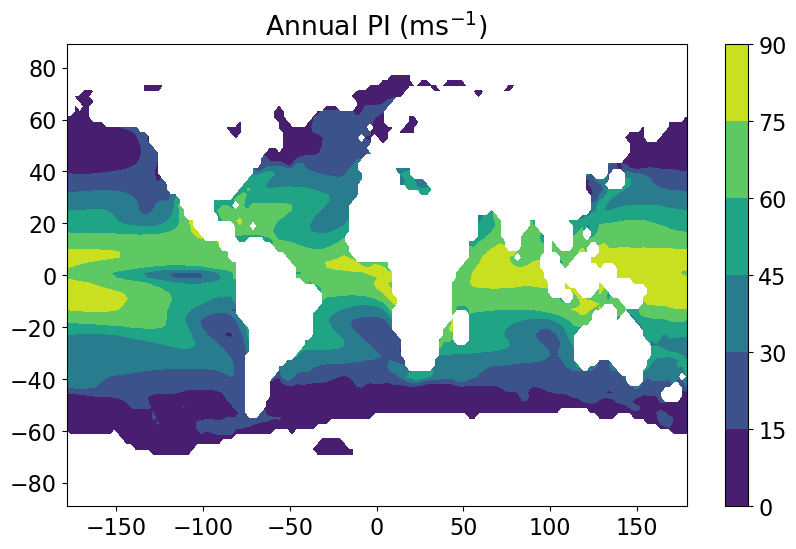

In [106]:
plt.figure(figsize=(10,6))
plt.contourf(full_ds.lon,full_ds.lat,full_ds.vmax.mean(dim=['month']))
# plt.xlabel(full_ds.lon.ame)
# plt.ylabel(full_ds.lat.standard_name)standard_n
plt.title('Annual PI (ms$^{-1}$)')
plt.colorbar()
plt.show()

### Sea Surface Temperature ($T_{s}$)

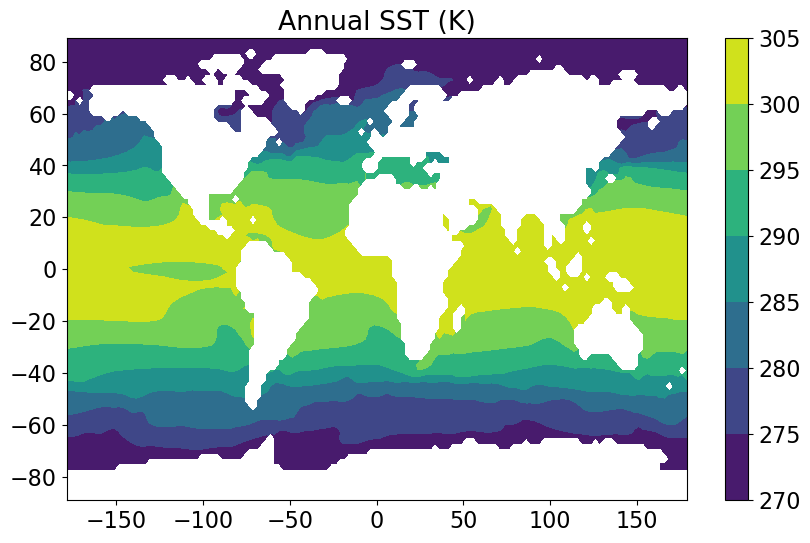

In [107]:
plt.figure(figsize=(10,6))
plt.contourf(full_ds.lon,full_ds.lat,273.15+full_ds.sst.mean(dim=['month']))
# plt.xlabel(full_ds.lon.standard_name)
# plt.ylabel(full_ds.lat.standard_name)
plt.title('Annual SST (K)')
plt.colorbar()
plt.show()

### Outflow Temperature ($T_0$)

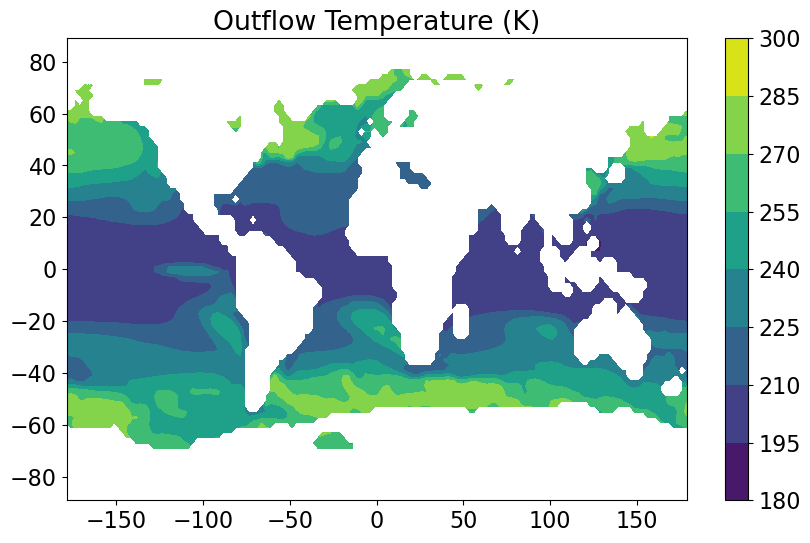

In [108]:
plt.figure(figsize=(10,6))
plt.contourf(full_ds.lon,full_ds.lat,full_ds.t0.mean(dim=['month']))
# plt.xlabel(full_ds.lon.standard_name)
# plt.ylabel(full_ds.lat.standard_name)
plt.title('Outflow Temperature (K)')
plt.colorbar()
plt.show()

### Outflow Temperature Level (OTL)

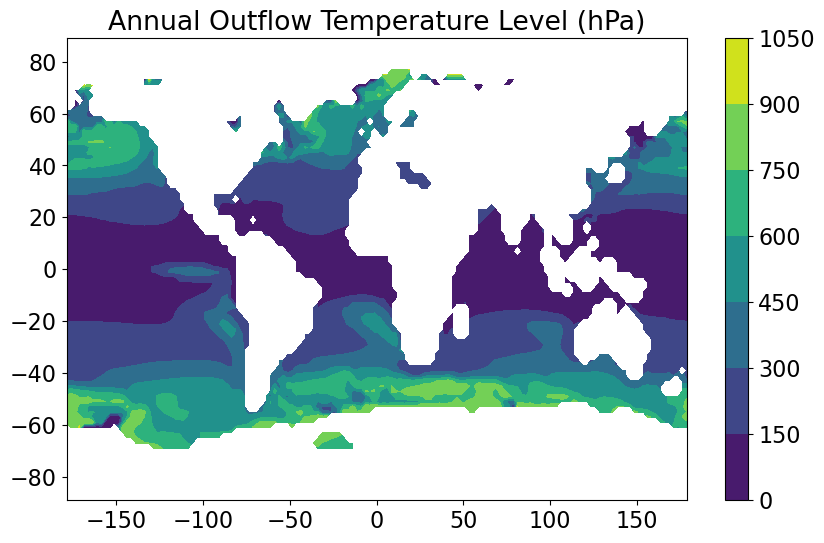

In [109]:
plt.figure(figsize=(10,6))
plt.contourf(full_ds.lon,full_ds.lat,full_ds.otl.mean(dim=['month']))
# plt.xlabel(full_ds.lon.standard_name)
# plt.ylabel(full_ds.lat.standard_name)
plt.title('Annual Outflow Temperature Level (hPa)')
plt.colorbar()
plt.show()

### TC Efficiency ($\frac{T_{s} - T_{0}}{T_{0}}$)

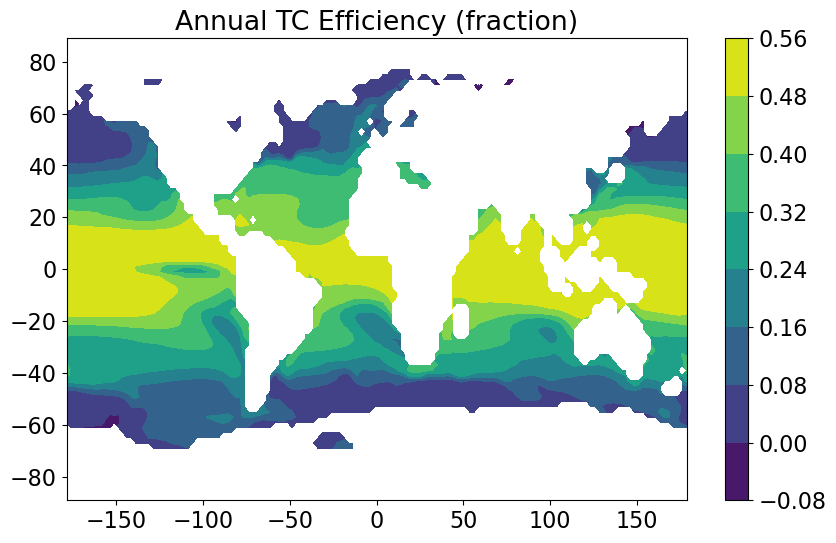

In [110]:
plt.figure(figsize=(10,6))
plt.contourf(full_ds.lon,full_ds.lat,full_ds.eff.mean(dim=['month']))
# plt.xlabel(full_ds.lon.standard_name)
# plt.ylabel(full_ds.lat.standard_name)
plt.title('Annual TC Efficiency (fraction)')
plt.colorbar()
plt.show()

### Disequlibrium ($h_0^* - h^*$)

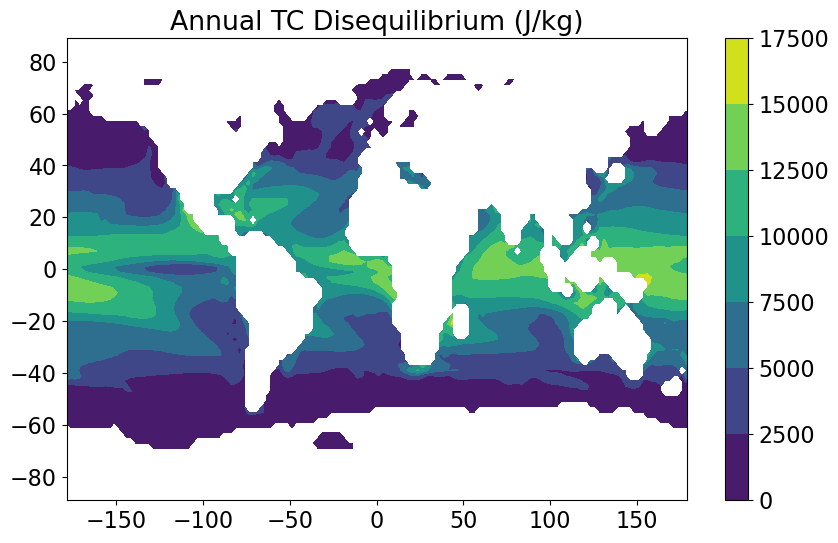

In [111]:
plt.figure(figsize=(10,6))
plt.contourf(full_ds.lon,full_ds.lat,full_ds.diseq.mean(dim=['month']))
# plt.xlabel(full_ds.lon.standard_name)
# plt.ylabel(full_ds.lat.standard_name)
plt.title('Annual TC Disequilibrium (J/kg)')
plt.colorbar()
plt.show()

## Seasonal Climatology

Repeating some of the analyses from Gilford et al. ([2017](https://journals.ametsoc.org/doi/full/10.1175/JCLI-D-16-0827.1)) demonstrates the useful of the PI metric for understanding how the maximum speed limits of tropical cyclones in climate system varies on an intraseasonal basis.

First, calculate the global average PI seasonal cycle, then apply basin masks to explore the seasonal variability from basin to basin.

### Global Mean Average of $V_{max}$

In [112]:
# calculate the latitude weighting
weights = np.cos(np.deg2rad(full_ds.lat))
weights.name = "weights"
# example: apply weighting to calculate global seasonal averages
full_ds.vmax.weighted(weights).mean(("lon", "lat"));

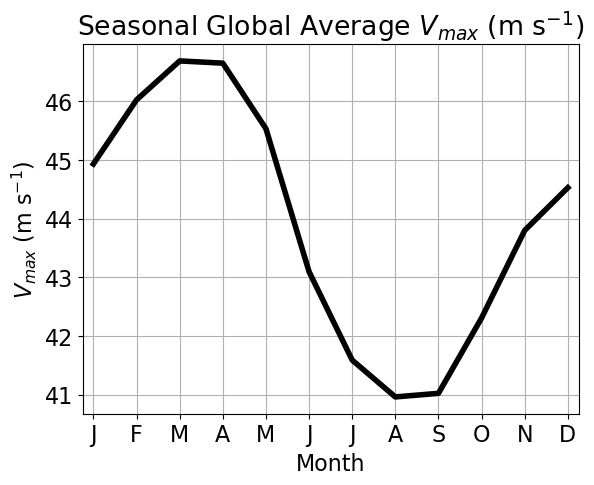

In [114]:
# plot the global mean annual cycle (adding stdev errorbars shows how variable Vmax is spatially)
plt.figure()
plt.plot(np.arange(1,13,1),full_ds.vmax.weighted(weights).mean(("lon", "lat")),'k',lw=4)
# plt.errorbar(np.arange(1,13,1),pi_ds.vmax.weighted(weights).mean(("lon", "lat")), \
#            pi_ds.vmax.std(("lon", "lat")))
plt.xlim([0.75,12.25])
plt.xticks(np.arange(1,13,1),labels=monlabels)
plt.xlabel('Month')
plt.ylabel('$V_{max}$ (m s$^{-1}$)')
plt.title('Seasonal Global Average $V_{max}$ (m s$^{-1}$)')
plt.grid()
plt.show()

### Mean Seasonal Cycles by Main Development Region (basins)

Take averages over each TC main development region; ensure that result is weighted by latitude.

In [115]:
# define the function to calculate basin averaged variables
def basin_avg(dat_array,basin_dict):
    
    # calculate latitude weighting
    weights = np.cos(np.deg2rad(dat_array.lat))
    
    # find the basin locations in the data structure
    var_slice=dat_array.sel(lon=slice(basin_dict.bounds.values[1,0], basin_dict.bounds.values[1,1]), \
                         lat=slice(basin_dict.bounds.values[0,1], basin_dict.bounds.values[0,0]))
    
    # take latitude weighted basin average
    basin_mean=var_slice.weighted(weights).mean(("lon", "lat"))
    
    # return the basin mean
    return(basin_mean)

Iterate over this function to produce seasonal cycle means for each basin and variable.

In [116]:
# ignore future warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# create a dictionary to store results
meanb={}
# calculate basin averages for each basin and variable#
# loop over the variables
for j in full_ds.keys():
    # only run analyses on the month/lat/lon variables
    if (full_ds[j].ndim==3) and (full_ds[j].name!='ifl'):
        # loop over the basins
        hold={}
        for b in basins.keys():
            _output=basin_avg(full_ds[j],basins[b])
            hold[b]=_output
            # store the variables
        meanb[j]=hold
        # store the variable names
        meanb[j]['name'] = getattr(full_ds[j], 'standard_name', j) 
        # ignore units for log variables, else store them
        if (full_ds[j].name[:2]!='ln'):
            meanb[j]['units']=full_ds[j].units
        del hold

{'sst': {'na': <xarray.DataArray 'sst' (month: 12)> Size: 96B
  array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])
  Coordinates:
    * month     (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
      st_ocean  float64 8B 5.0,
  'enp': <xarray.DataArray 'sst' (month: 12)> Size: 96B
  array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])
  Coordinates:
    * month     (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
      st_ocean  float64 8B 5.0,
  'wnp': <xarray.DataArray 'sst' (month: 12)> Size: 96B
  array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])
  Coordinates:
    * month     (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
      st_ocean  float64 8B 5.0,
  'ni': <xarray.DataArray 'sst' (month: 12)> Size: 96B
  array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])
  Coordinates:
    * month     (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
      st_ocean  float64 8B 5.0,
  'sh': <xarray.DataArray 'sst' (month: 12)> Size: 96B
  ar

Now write a function to quickly plot the seasonal cycles.

In [117]:
# define the function to plot the seasonal cycle of a variable
def plot_pi_seascycle(var_want,meanb,basin_dict):
    plt.figure()
    mongrid=np.linspace(1,12,12)
    for k in basins.keys():
        plt.plot(mongrid,meanb[var_want][k],lw=4,color=str(basins[k].color.values),label=str(basins[k].shortname.values))
    plt.xlim([0.75,12.25])
    plt.xticks(mongrid,labels=monlabels)
    plt.xlabel('Month')
    plt.ylabel(meanb[var_want]['name']+' ('+meanb[var_want]['units']+')',fontsize=12)
    plt.title('Seasonal Mean '+meanb[var_want]['name']+' ('+meanb[var_want]['units']+')',fontsize=16)
    plt.legend(fontsize=12,loc='best')
    plt.grid()
    plt.show()
    return None

### $V_{max}$

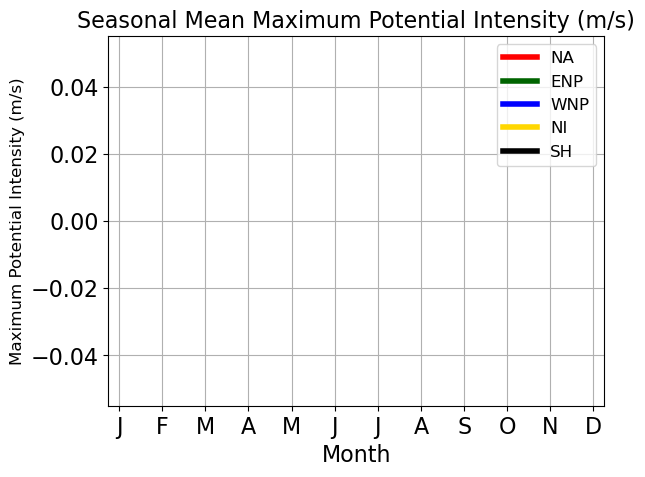

In [118]:
plot_pi_seascycle('vmax',meanb,basins)

### SST

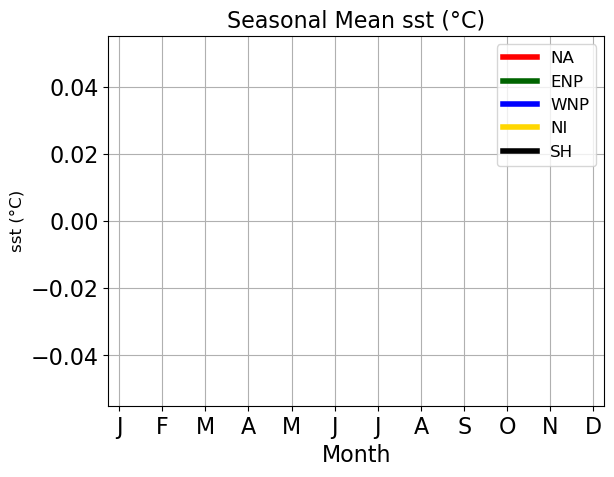

In [119]:
plot_pi_seascycle('sst',meanb,basins)

### $T_{0}$

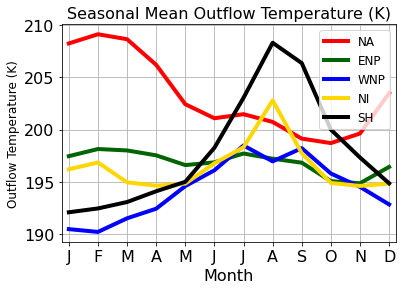

In [24]:
plot_pi_seascycle('t0',meanb,basins)

### OTL

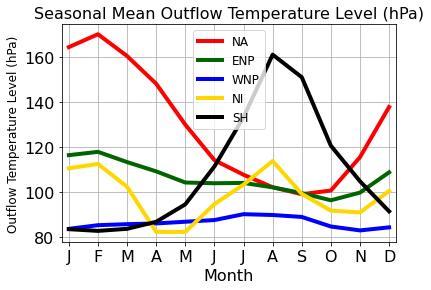

In [25]:
plot_pi_seascycle('otl',meanb,basins)

### Efficiency

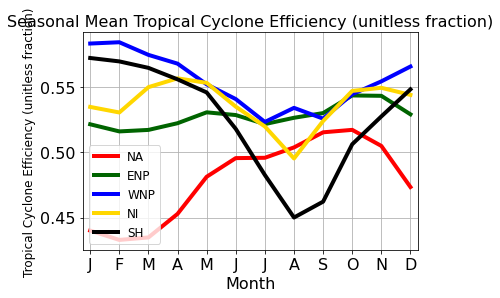

In [26]:
plot_pi_seascycle('eff',meanb,basins)

### Disequlibrium

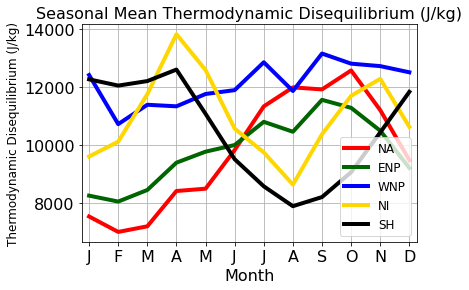

In [27]:
plot_pi_seascycle('diseq',meanb,basins)

### Factors contributing to seasonal PI variability

Calculate the seasonal amplitude of each term in the decomposition, and print (see Gilford et al. 2017, Table 2). Note that a negative seasonal cycle indicates that the term in the boreal winter is higher than the boreal summer.

In [28]:
# create arrays for output
lnpi_seasA=np.zeros((len(basins.keys()),1),dtype='float64')
lneff_seasA=np.zeros((len(basins.keys()),1),dtype='float64')
lndiseq_seasA=np.zeros((len(basins.keys()),1),dtype='float64')
lnpi_seasA[:],lnpi_seasA[:],lnpi_seasA[:]=np.nan,np.nan,np.nan
# define the count
k=0
# get the seasonal amplitudes of each decomposition term
for key in basins.keys():
    
    lnpi_seasA[k]=np.ptp(meanb['lnpi'][key].values)
    lneff_seasA[k]=np.ptp(meanb['lneff'][key].values)
    lndiseq_seasA[k]=np.ptp(meanb['lndiseq'][key].values)
    # convention: set any values greater in boreal winter than summer to negative
    if meanb['lnpi'][key].values[10]<=meanb['lnpi'][key].values[2]:
        lnpi_seasA[k]=-lnpi_seasA[k]
    if meanb['lneff'][key].values[10]<=meanb['lneff'][key].values[2]:
        lneff_seasA[k]=-lneff_seasA[k]
    if meanb['lndiseq'][key].values[10]<=meanb['lndiseq'][key].values[2]:
        lndiseq_seasA[k]=-lndiseq_seasA[k]
    # increment
    k=k+1

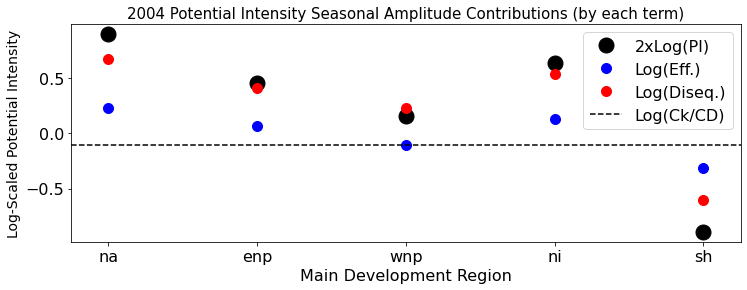

In [29]:
# plot the result
plt.figure(figsize=(12,4))
plt.plot(lnpi_seasA,'ko',label='2xLog(PI)',markersize=15)
plt.plot(lneff_seasA,'bo',label='Log(Eff.)',markersize=10)
plt.plot(lndiseq_seasA,'ro',label='Log(Diseq.)',markersize=10)
plt.plot([-0.25,4.25],[full_ds.lnCKCD,full_ds.lnCKCD],'k--',label='Log(Ck/CD)')
plt.xlim([-0.25,4.25])
plt.xticks(np.arange(5),labels=basins.keys())
plt.legend(loc='upper right')
plt.ylabel('Log-Scaled Potential Intensity',fontsize=14)
plt.title('2004 Potential Intensity Seasonal Amplitude Contributions (by each term)', \
            fontsize=15)
plt.xlabel('Main Development Region')
plt.show()

# Conclusion

Tropical cyclone potential intensity is a powerful tool for understanding the factors which contribute to the speed limits on intensities. Sea surface temperatures and outflow temperatures control the bulk of PI variance on all time scales, but have unique roles in driving PI over the seasonal cycle. This notebook has reproduced a single year of the seasonal analyses of Gilford et al. (2017). Further analyses is warranted, but beyond the scope of the pyPI project.

To learn more or provide any questions or comments, please contact Daniel Gilford, PhD (dgilford@climatecentral.org).